# This code:

1. Compares the temporal evolution of the flexural deflection and transit distance extracted at the river mouth (RMT). 
2. Plots the power spectral density (PSD) for simulations with a frequency of 5 Myr (red) and 500 kyr (grey). The correspondence in peak frequencies between sea level, flexural deflection, and river mouth
migration provides further evidence of the synchronicity between flexural deflection and sea level changes.

In [1]:
import glob
import numpy as np
import pandas as pd
import plotly
import matplotlib.pyplot as plt
from scipy import signal
import scipy
from scipy.ndimage import gaussian_filter1d
import matplotlib.lines as mlines


# Loading the data

In [2]:
#Sea-level curves
geo_wave_100=np.arange(-3*np.pi, -1*np.pi, (((3*np.pi)-(1*np.pi))/1e2))
rounding=2

A25m=25/2 #This means amplitude is -12.5 and +12.5
A50m=50/2 #This means amplitude is -25 and +25
A100m=100/2#This means amplitude is -50 and +50
f_0_1Ma=-10e6/.1e6 #20 full cycles, each of 0.5 Ma I made negative so that SL is low and delta progrades easily
f_0_5Ma=-10e6/.5e6 #20 full cycles, each of 0.5 Ma I made negative so that SL is low and delta progrades easily
f_5Ma=-10e6/5e6 

#path='/live/share/Badlands_simulations'
# Loading the files with the metrics e.g. flexure, accumulation
Delta_SL0_Te50=pd.read_csv ('extracted_results/Synthetic/Delta_SL0_Te50.csv',sep=',', header=0)
Delta_SL_f5Myr_A25m_Te50=pd.read_csv('extracted_results/Synthetic/Delta_SL_f5Myr_A25m_Te50.csv', sep=',',header=0)
Delta_SL_f500Kyr_A25m_Te50=pd.read_csv ('extracted_results/Synthetic/Delta_SL_f500Kyr_A25m_Te50.csv',sep=',', header=0)

#Loading the sea level curves
Delta_SL_f5Myr_A25m=pd.read_csv('../../2_model_running/data/f5Myr_A25m.csv', sep=' ',header=None)
Delta_SL_f500Kyr_A25m=pd.read_csv('../../2_model_running/data/f500Kyr_A25m.csv', sep=' ',header=None)


sims=[Delta_SL0_Te50,Delta_SL_f5Myr_A25m_Te50, Delta_SL_f500Kyr_A25m_Te50]


In [3]:
#Spectral analysis
nperseg=99
nperseg=99
#Power spectra - Sea level
freqA25mf0_1Ma_1e2, psdA25mf0_1Ma_1e2=signal.welch(np.round(np.sin(geo_wave_100*f_0_1Ma),rounding)*A50m, nperseg = nperseg)
freqA25mf0_5Ma_1e2, psdA25mf0_5Ma_1e2=signal.welch(np.round(np.sin(geo_wave_100*f_0_5Ma),rounding)*A50m, nperseg = nperseg)
freqA25mf5Ma_1e2, psdA25mf5Ma_1e2=signal.welch(np.round(np.sin(geo_wave_100*f_5Ma),rounding)*A50m, nperseg = nperseg)

# Power spectra and detrending - Flexure
SW_Delta_SL_f5Myr_A25m_Te50_f_dt=signal.welch(signal.detrend(Delta_SL_f5Myr_A25m_Te50.Flexure_m[20:-1]),nperseg = nperseg)
SW_Delta_SL_f500Kyr_A25m_Te50_f_dt=signal.welch(signal.detrend(Delta_SL_f500Kyr_A25m_Te50.Flexure_m[20:-1]),nperseg = nperseg)

# Power spectra and detrending - River mouth distance
SW_Delta_SL_f5Myr_A25m_Te50_drm_dt=signal.welch(signal.detrend(Delta_SL_f5Myr_A25m_Te50.River_mouth_Lengh_m[20:-1]),nperseg = nperseg)
SW_Delta_SL_f500Kyr_A25m_Te50_drm_dt=signal.welch(signal.detrend(Delta_SL_f500Kyr_A25m_Te50.River_mouth_Lengh_m[20:-1]),nperseg = nperseg)

# Power spectra and detrending - Accumulation
SW_Delta_SL_f5Myr_A25m_Te50_acc_dt=signal.welch(signal.detrend(Delta_SL_f5Myr_A25m_Te50.Accumulation_m[20:-1]),nperseg = nperseg)
SW_Delta_SL_f500Kyr_A25m_Te50_acc_dt=signal.welch(signal.detrend(Delta_SL_f500Kyr_A25m_Te50.Accumulation_m[20:-1]),nperseg = nperseg)


In [4]:
#normalization function
def normalized(x, xmin, xmax):
    try:
        normalized = (x- xmin)/(xmax - xmin)
    except ZeroDivisionError:
        percentage = float('inf')
    return normalized

In [5]:
#Finding the global min and max

min_flex=np.zeros(len(sims))
max_flex=np.zeros(len(sims))
min_dist=np.zeros(len(sims))
max_dist=np.zeros(len(sims))

sigma=[6,4,1]
for i in np.arange(0,len(sims), 1):
    min_flex[i]=min(gaussian_filter1d(sims[i].Flexure_m,sigma[i]))
    max_flex[i]=max(gaussian_filter1d(sims[i].Flexure_m,sigma[i]))
    min_dist[i]=min(gaussian_filter1d(sims[i].X[1:-1],sigma[i]))
    max_dist[i]=max(gaussian_filter1d(sims[i].X[1:-1],sigma[i]))
    

#calculating the maximum rate of flexure
max_rate_flex= np.zeros(len(sims))
#mm/yr
for i in np.arange(0,len(sims), 1):
    max_rate_flex[i]=abs(np.round((min_flex[i]*1e3)/(12*1e6),3))
    
max_rate_flex

array([0.103, 0.075, 0.074])

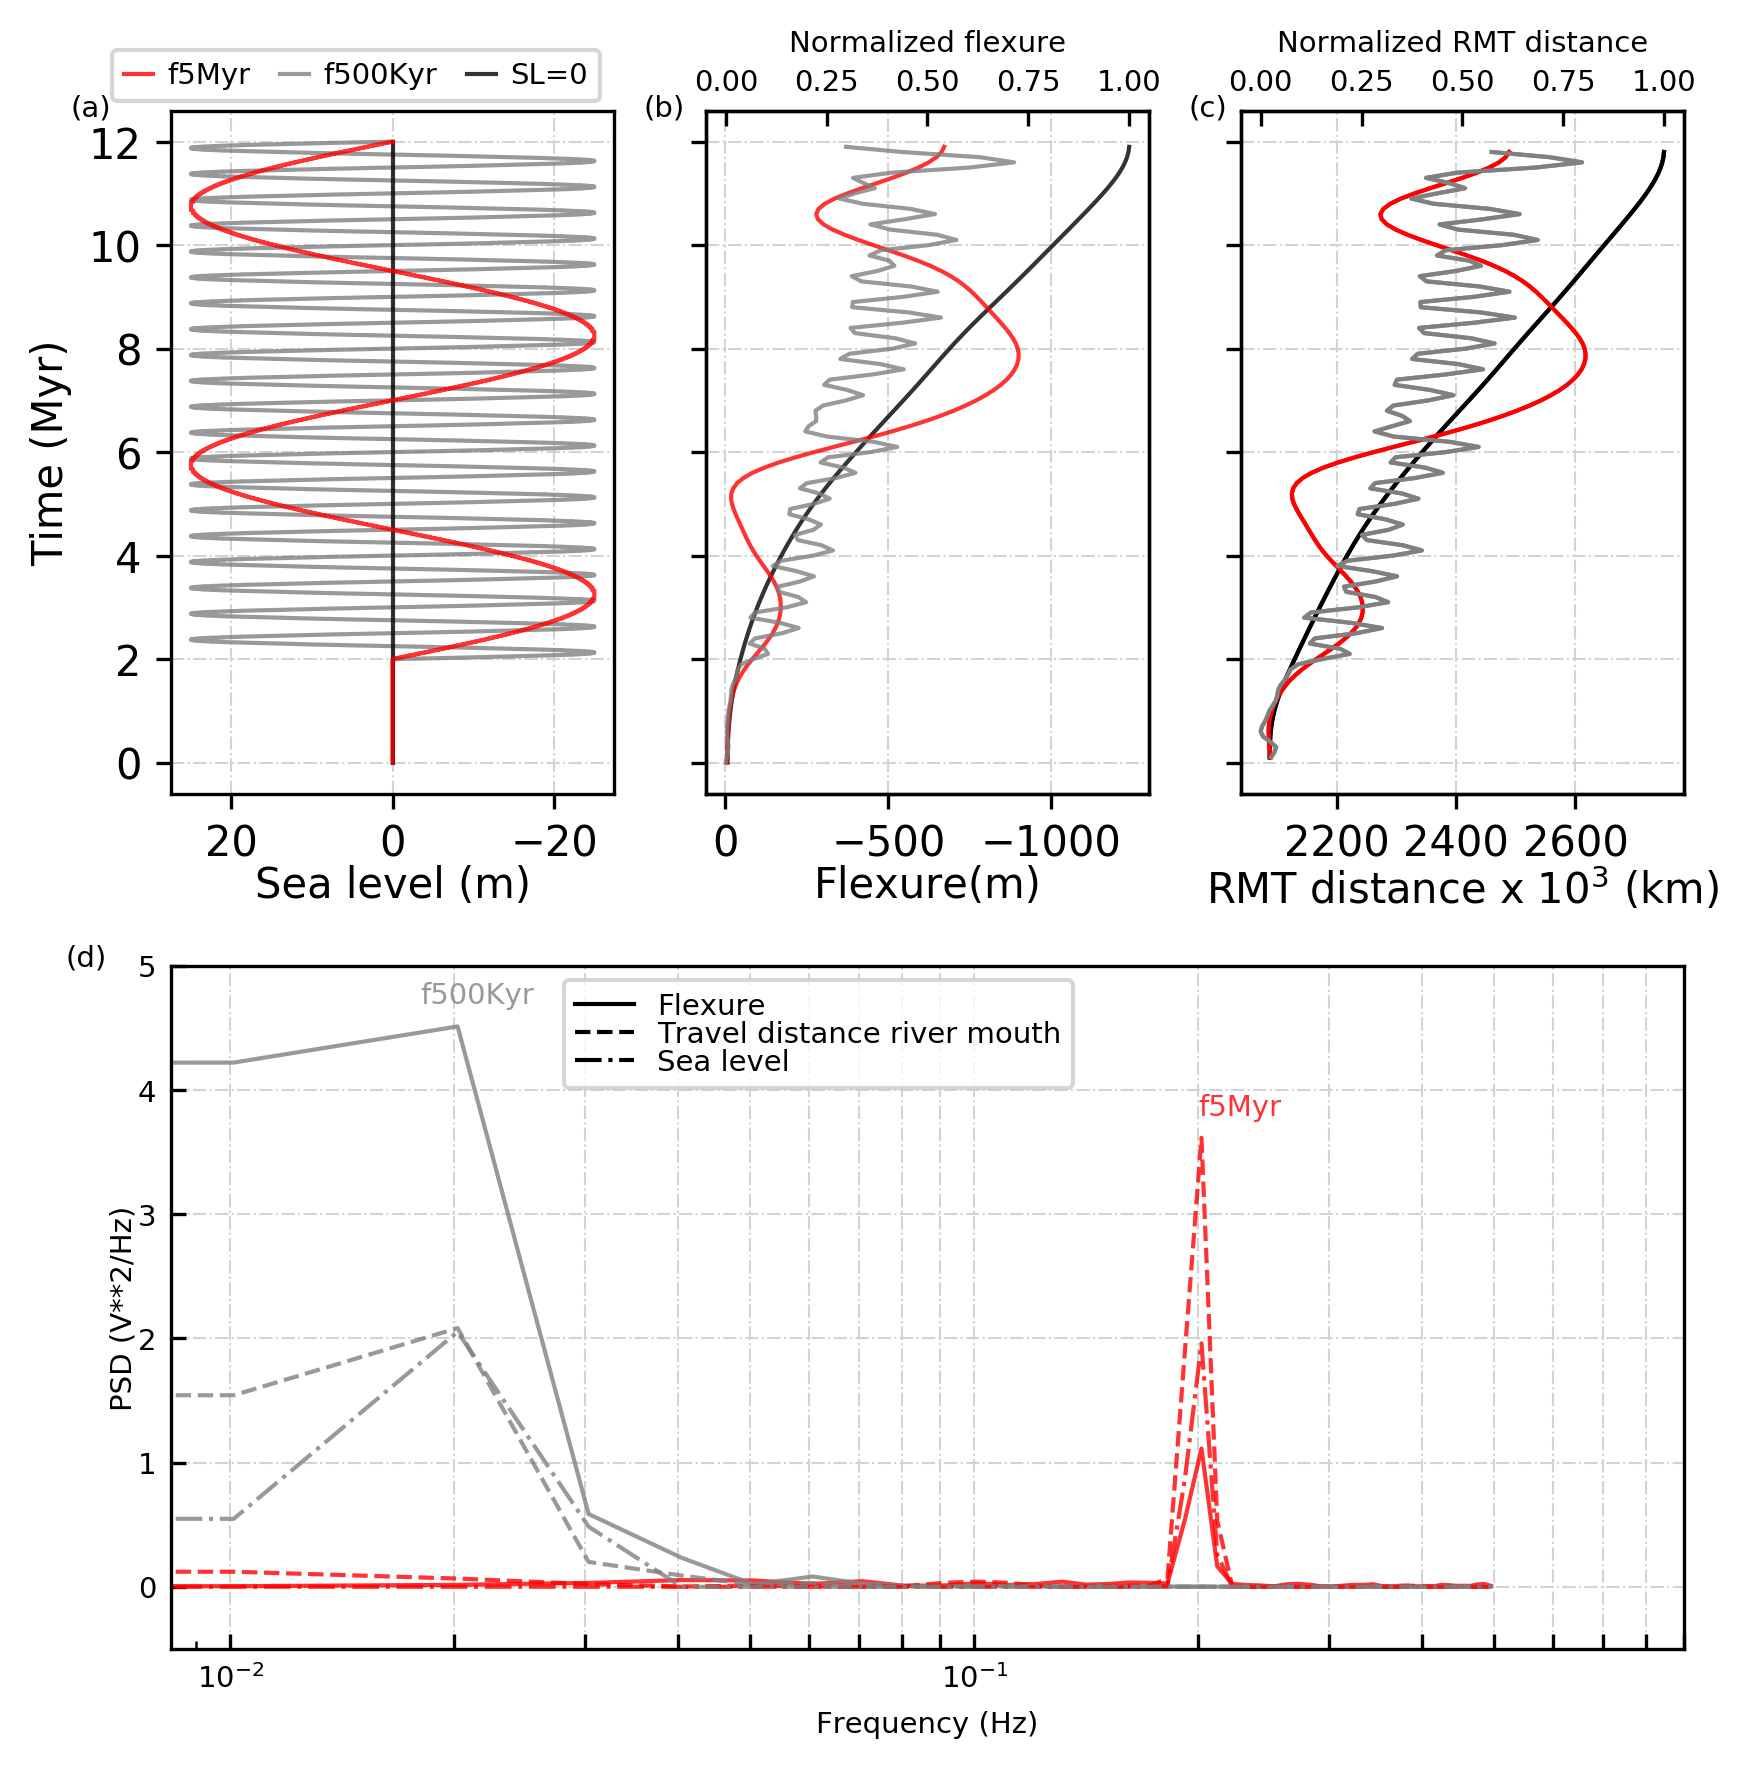

In [6]:
#Flexure&normalize flexure, power spectra at the bottom

nrows=2; ncols=3

fig,axes = plt.subplots(nrows=nrows,ncols=ncols, figsize = (15/2.54, 15/2.54), dpi=300, sharey=True)
colors=['black',  'red','grey']
plt.rc("font", size=7); plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42
abc=['(a)', '(b)', '(c)']
xabc=[40,250,1.95e3]
alpha=0.8
sigma=[6,4,1]

nfile=len(Delta_SL0_Te50.X)
ts=np.arange(0,nfile,1)
realtime=(ts*10e6)/100

SLf=1e-4
Ff=1e-6
DRMf=1e-12

###########
#First row#
###########
#Sea level
axes.flatten()[0].plot(Delta_SL_f5Myr_A25m[1],Delta_SL_f5Myr_A25m[0]/1e6, color=colors[1], linewidth=1, alpha=alpha, label='f5Myr', zorder=3) 
axes.flatten()[0].plot(Delta_SL_f500Kyr_A25m[1],Delta_SL_f500Kyr_A25m[0]/1e6, color=colors[2], linewidth=1, alpha=alpha, label='f500Kyr') 
axes.flatten()[0].plot([0, 0],[0, 12], color=colors[0], linewidth=1, alpha=alpha, label='SL=0')

for i in np.arange(0,len(sims), 1):
    axes.flatten()[1].plot(gaussian_filter1d(sims[i].Flexure_m,sigma[i]), realtime/1e6,
                        color=colors[i], linewidth=1, alpha=alpha) 
    axes.flatten()[i].text(xabc[i], 12.5, str(abc[i]))


ax1t = axes.flatten()[1].twiny() 
for i in np.arange(0,len(sims), 1):
    ax1t.plot(normalized(gaussian_filter1d(sims[i].Flexure_m,sigma[i])
                        , min(min_flex)
                        , max(max_flex)), realtime/1e6,
            color=colors[i], linewidth=1, alpha=0, ) 

for i in np.arange(0,len(sims), 1):
    axes.flatten()[2].plot(gaussian_filter1d(sims[i].X[1:-1]/1e3,sigma[i]), realtime[1:-1]/1e6,
                        color=colors[i], linewidth=1, alpha=alpha) 

ax2t = axes.flatten()[2].twiny() 
for i in np.arange(0,len(sims), 1):
    ax2t.plot(normalized(gaussian_filter1d(sims[i].X[1:-1],sigma[i])
                        , min(min_dist)
                        , max(max_dist)), realtime[1:-1]/1e6,
            color=colors[i], linewidth=1, alpha=1 ) 
# Top Legend 
axes.flatten()[0].legend(bbox_to_anchor=[1,1.11], ncol=3,
                         labelspacing=0.1, columnspacing=1, handlelength=1, handletextpad=0.5)
axes.flatten()[0].set_ylabel('Time (Myr)')

###############
#Power spectra#
###############
axb=plt.subplot2grid((nrows,ncols),(nrows-1,0), colspan=3)
#Flexure
axb.semilogx(SW_Delta_SL_f500Kyr_A25m_Te50_f_dt[0], SW_Delta_SL_f500Kyr_A25m_Te50_f_dt[1]*Ff, c='red', linewidth=1, alpha=alpha, label='f5Myr flexure')
axb.semilogx(SW_Delta_SL_f5Myr_A25m_Te50_f_dt[0], SW_Delta_SL_f5Myr_A25m_Te50_f_dt[1]*Ff, c='grey', linewidth=1, alpha=alpha, label='f500Kyr flexure')
#Distance to river mouth
axb.semilogx(SW_Delta_SL_f500Kyr_A25m_Te50_drm_dt[0], SW_Delta_SL_f500Kyr_A25m_Te50_drm_dt[1]*DRMf,'--', linewidth=1, alpha=alpha,c='red', label='f5Myr river mouth')
axb.semilogx(SW_Delta_SL_f5Myr_A25m_Te50_drm_dt[0], SW_Delta_SL_f5Myr_A25m_Te50_drm_dt[1]*DRMf, '--', linewidth=1, alpha=alpha, c='grey', label='f500Kyr river mouth')
#Sea level
axb.semilogx(freqA25mf0_5Ma_1e2, psdA25mf0_5Ma_1e2*SLf,'-.', label='f5Myr Sea Level', c='red', linewidth=1, alpha=alpha)
axb.semilogx(freqA25mf5Ma_1e2, psdA25mf5Ma_1e2*SLf, '-.', label='f500Kyr Sea Level', c='grey', linewidth=1, alpha=alpha)
axb.text(0.018,4.7, 'f500Kyr', color='grey',  alpha=alpha)
axb.text(0.2,3.8, 'f5Myr', color='red' , alpha=alpha)
axb.set_xlabel('Frequency (Hz)')
axb.set_ylabel('PSD (V**2/Hz)',labelpad=0.10)
axb.set_ylim([-0.5, 5])

############
##Formating#
############
axb.text(6e-3,5, s='(d)')
axb.set_xticks(np.append(np.arange(1e-2, 1e-1, 1e-2), np.arange(1e-1, 1e-0, 1e-1)))
axb.tick_params(direction= 'in', which='both')
axb.grid(color='lightgrey', linestyle='-.', linewidth=0.5)


# Bottom Legend 
sea_level = mlines.Line2D([], [], color='k', linestyle='-.', linewidth=1, label='Sea level')
flexure= mlines.Line2D([], [], color='k',linewidth=1, label='Flexure')
distance= mlines.Line2D([], [], color='k',linestyle='--', linewidth=1,label='Travel distance river mouth')
axb.legend(bbox_to_anchor=[0.25,1],handles=[flexure, distance,sea_level],  labelspacing=0.001)


ax1t.tick_params(direction= 'in', which='both')
ax2t.tick_params(direction= 'in', which='both')
#ax2t.tick_params([])

ax1t.set_xlabel('Normalized flexure') 
ax2t.set_xlabel('Normalized RMT distance') 


xlabels= ['Sea level (m)', 'Flexure(m)', 'RMT distance x $10^3$ (km)', '', 'Flexural departure (m)', 'RMT distance departure (km)']
for i in np.arange(0, ncols*nrows,1):
    #axes.flatten()[i].tick_params(direction= 'in', which='both')
    axes.flatten()[i].grid(color='lightgrey', linestyle='-.', linewidth=0.5)
    if i<=1:
        axes.flatten()[i].invert_xaxis()

    if i<=5:
        axes.flatten()[i].set_xlabel(str(xlabels[i]), labelpad=0.01)
    
fig.tight_layout()

fig.savefig('./images/egusphere-2023-53_Fig7.jpg')